In [122]:
cd("/Users/evanrussek/forage_jsp/analysis/")

using CSV
using DataFrames
using DataFramesMeta
using CategoricalArrays
using Gadfly
using MixedModels
using StatsBase
using Statistics
using TableView
import Cairo


In [5]:
data = CSV.read("data/run5_data.csv");
# add s_num to it as a factor, get number of subjects
data.s_num = groupindices(groupby(data,:subjectID));
data.subj = CategoricalArray(data.s_num);
n_subj = length(unique(data.subj));

# define travel keys - we checked before that 1 is easy, 2 is hard
travel_keys = unique(data.travel_key)
travel_key_easy = travel_keys[1];
travel_key_hard = travel_keys[2];

In [6]:
function clean_subj_data(s_data)
        # clean subject 1 data...
        s_data = @select(s_data,:round, :phase, :reward_obs,
                                :reward_true, :lag, :exit, :start_reward, :n_travel_steps,
                                :travel_key, :subjectID, :trial_num, :s_num, :correct_key)

        # compute pressnum column... is there as simpler way to do this?
        trial_press_num_df = by(s_data,:trial_num, df -> DataFrame(press_num = 1:nrow(df)))
        s_data.press_num = trial_press_num_df.press_num

        # change phase name, travel_key
        s_data = @byrow! s_data begin
                if :phase == "Harvest"
                :phase = "HARVEST"
                end
                @newcol travel_key_cond::Array{String,1}
                if :travel_key == travel_key_hard
                        :travel_key_cond = "HARD"
                else
                        :travel_key_cond = "EASY"
                end
        end

        return s_data
end

clean_subj_data (generic function with 1 method)

In [7]:
# aggregate all clean data...
cdata = DataFrame();
for s = 1:n_subj
        global cdata
        s_data = @where(data,:subj .== s)
        cdata = vcat(cdata,clean_subj_data(s_data))
end


In [8]:
head(cdata)

┌ Warning: `head(df::AbstractDataFrame)` is deprecated, use `first(df, 6)` instead.
│   caller = top-level scope at In[8]:1
└ @ Core In[8]:1


,round,phase,reward_obs,reward_true,lag,exit,start_reward,n_travel_steps
,Int64,String,Float64⍰,Float64⍰,Float64,Float64⍰,Int64,Int64
1,1,TRAVEL,missing,missing,1769.67,missing,60,16
2,1,TRAVEL,missing,missing,187.805,missing,60,16
3,1,TRAVEL,missing,missing,173.26,missing,60,16
4,1,TRAVEL,missing,missing,121.57,missing,60,16
5,1,TRAVEL,missing,missing,359.97,missing,60,16
6,1,TRAVEL,missing,missing,313.64,missing,60,16


In [ ]:
# let's get the # of rounds for each subject


In [9]:
## Compute exit thresholds for each round/trial/subj/group
## function to compute exit for each round in a trial's data...
function get_trial_exits(trial_data)
        last_phase = trial_data.phase[end]
        if (last_phase == "HARVEST")
                last_round = trial_data.round[end]
                trial_data = @where(trial_data, :round .!= last_round)
        end

        trial_data = @where(trial_data, .&(:phase .== "HARVEST", missing .!== :reward_obs))

        if size(trial_data,1) > 0
                exit_tbl = by(trial_data, :round,
                        last_reward = :reward_obs => last,
                        #trial_num = :trial_num => first,
                        phase = :phase => first,
                        start_reward = :start_reward => first,
                        travel_key_cond = :travel_key_cond => first
                        )
        else
                exit_tbl = DataFrame(last_reward = [],
                        #trial_num = [],
                        phase = [],
                        start_reward = [],
                        travel_key_cond = [],
                        round = [])
        end
        return exit_tbl
end

get_trial_exits (generic function with 1 method)

In [11]:
# exit_data for each round for each trial for each subject
round_exit_data = by(cdata, [:s_num, :trial_num], df -> get_trial_exits(df));

In [216]:
# get number of rounds for each subject...
rc_df = by(round_exit_data, [:s_num, :start_reward, :travel_key_cond, :phase], 
    df -> DataFrame(round_count = size(df,1)));


# let's make a histogram of round_counts by condition...
nr_plot = plot(sort(rc_df, :start_reward), x=:round_count, xgroup = :travel_key_cond, ygroup = :start_reward,
    Geom.subplot_grid(Geom.histogram),
    Guide.xlabel("# of rounds by travel key"),
    Guide.ylabel("# subjects by start reward"),
    Guide.title("Number of rounds"))

# save this plot...
draw(PNG("plots/n_round_hist.png", 4inch, 4inch), nr_plot)


In [21]:
first_round_exit = @where(round_exit_data, :round.==1);
#head(first_round_exit)
# exit data for each trial, for each subject
fr_trial_exit_data = by(first_round_exit, [:s_num,:start_reward,:travel_key_cond],
                        exit_thresh = :last_reward => mean,
                        trial_num = :trial_num => first,
                        );
# exit data for each trial, aggregated over subjects
group_exit_data = by(fr_trial_exit_data, [:start_reward, :travel_key_cond],
                df -> DataFrame(
                        exit_thresh = mean(df[:exit_thresh]),
                        exit_sem = std(df[:exit_thresh])/sqrt(nrow(df)),
                        ))

┌ Warning: `getindex(sdf::SubDataFrame, colind::ColumnIndex)` is deprecated, use `sdf[!, colind]` instead.
│   caller = (::var"#50#51")(::SubDataFrame{DataFrame,DataFrames.Index,Array{Int64,1}}) at In[21]:10
└ @ Main ./In[21]:10
┌ Warning: `getindex(sdf::SubDataFrame, colind::ColumnIndex)` is deprecated, use `sdf[!, colind]` instead.
│   caller = (::var"#50#51")(::SubDataFrame{DataFrame,DataFrames.Index,Array{Int64,1}}) at In[21]:10
└ @ Main ./In[21]:10


,start_reward,travel_key_cond,exit_thresh,exit_sem
,Any,Any,Float64,Float64
1,60,EASY,27.7704,1.80855
2,120,HARD,42.9814,3.40957
3,90,HARD,35.4426,2.60815
4,60,HARD,23.9872,1.84466
5,90,EASY,39.0348,2.55819
6,120,EASY,48.5874,3.05273


In [22]:
# make a function to make the group exit data for a specific round...
function make_group_exit_data_round(cdata, round_number)
    first_round_exit = @where(round_exit_data, :round.==round_number);
    #head(first_round_exit)
    # exit data for each trial, for each subject
    fr_trial_exit_data = by(first_round_exit, [:s_num,:start_reward,:travel_key_cond],
                            exit_thresh = :last_reward => mean,
                            trial_num = :trial_num => first,
                            );
    # exit data for each trial, aggregated over subjects
    group_exit_data = by(fr_trial_exit_data, [:start_reward, :travel_key_cond],
                    df -> DataFrame(
                            exit_thresh = mean(df[:exit_thresh]),
                            exit_sem = std(df[:exit_thresh])/sqrt(nrow(df)),
                            ))
    return group_exit_data
end



make_group_exit_data_round (generic function with 1 method)

In [163]:
# make folder for plots...
exit_plot_round_folder = "plots/exit_by_round_plots";
if ~isdir(exit_plot_round_folder)
    mkdir(exit_plot_round_folder)
end


these_plots = Union{Plot}[]


for r_idx in 1:6

    r1g_exit_data = make_group_exit_data_round(cdata,r_idx);
    ### plot group mean exit thresholds by trial type
    exit_min = r1g_exit_data.exit_thresh - group_exit_data.exit_sem
    exit_max = r1g_exit_data.exit_thresh + group_exit_data.exit_sem
    group_exit_plot = plot(r1g_exit_data, x =:start_reward, y =:exit_thresh,
            color =:travel_key_cond,
            Geom.point, Geom.line, Geom.errorbar,
            #Guide.xlabel("Tree First Reward"),
            #Guide.ylabel("Last Reward Before Exit"),
            #Guide.title(string("Exit Threshold Group Means (N = 50), Round: ", r_idx)),
            Guide.colorkey(title="Travel Key"),
            Theme(line_width = 2pt))
    push!(these_plots, group_exit_plot)
    plot_file_name = string(exit_plot_round_folder, "/round_", r_idx, ".png")
    draw(PNG(plot_file_name, 4inch, 4inch), group_exit_plot)
    
    #plot(group_exit_plot)
    
end

┌ Warning: `setproperty!(df::DataFrame, col_ind::Symbol, v)` is deprecated, use `df[!, col_ind] .= v` instead.
│   caller = top-level scope at In[189]:5
└ @ Core ./In[189]:5


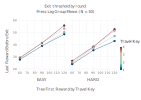

In [189]:
# want to alter this so that we only include subjects who completed # many rounds for each
all_round_group_exit_data = DataFrame();
for r_idx in 1:4
    round_group_exit_data = make_group_exit_data_round(cdata,r_idx);
    round_group_exit_data.round = r_idx;
    all_round_group_exit_data = [all_round_group_exit_data; round_group_exit_data];
end

all_round_group_exit_data = vcat(all_round_group_exit_data);

et_by_round = plot(all_round_group_exit_data, 
        x =:start_reward, y =:exit_thresh, color = :round, xgroup=:travel_key_cond,
        Geom.subplot_grid(Geom.line, Geom.point),
        Guide.title("Exit threshold by round"),
        Guide.ylabel("Last Reward Before Exit"),
        Guide.xlabel("Tree First Reward by Travel Key"),
        Guide.title("Press Lag Group Means (N = 50)"),
        Guide.colorkey(title="Travel Key")
)


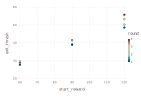

In [175]:
plot(@where(all_round_group_exit_data,:travel_key_cond .== "EASY"), 
        x =:start_reward, y =:exit_thresh, color = :round,
        )

In [172]:
@where(all_round_group_exit_data,:travel_key_cond .== "EASY")

,start_reward,travel_key_cond,exit_thresh,exit_sem,round
,Any,Any,Float64,Float64,Int64
1,60,EASY,27.7704,1.80855,1
2,90,EASY,39.0348,2.55819,1
3,120,EASY,48.5874,3.05273,1
4,60,EASY,28.4301,1.73848,2
5,90,EASY,39.065,2.16628,2
6,120,EASY,50.2808,3.21051,2
7,60,EASY,29.6539,1.53307,3
8,90,EASY,41.4886,2.41561,3
9,120,EASY,53.2201,2.71433,3


In [167]:
all_round_group_exit_data

6-element Array{Any,1}:
 6×5 DataFrame
│ Row │ start_reward │ travel_key_cond │ exit_thresh │ exit_sem │ round │
│     │ Any          │ Any             │ Float64     │ Float64  │ Int64 │
├─────┼──────────────┼─────────────────┼─────────────┼──────────┼───────┤
│ 1   │ 60           │ EASY            │ 27.7704     │ 1.80855  │ 1     │
│ 2   │ 120          │ HARD            │ 42.9814     │ 3.40957  │ 1     │
│ 3   │ 90           │ HARD            │ 35.4426     │ 2.60815  │ 1     │
│ 4   │ 60           │ HARD            │ 23.9872     │ 1.84466  │ 1     │
│ 5   │ 90           │ EASY            │ 39.0348     │ 2.55819  │ 1     │
│ 6   │ 120          │ EASY            │ 48.5874     │ 3.05273  │ 1     │
 6×5 DataFrame
│ Row │ start_reward │ travel_key_cond │ exit_thresh │ exit_sem │ round │
│     │ Any          │ Any             │ Float64     │ Float64  │ Int64 │
├─────┼──────────────┼─────────────────┼─────────────┼──────────┼───────┤
│ 1   │ 60           │ EASY            │ 28.4301     │ 1.7

In [108]:
r1g_exit_data

,start_reward,travel_key_cond,exit_thresh,exit_sem
,Any,Any,Float64,Float64
1,60,EASY,27.7704,1.80855
2,120,HARD,42.9814,3.40957
3,90,HARD,35.4426,2.60815
4,60,HARD,23.9872,1.84466
5,90,EASY,39.0348,2.55819
6,120,EASY,48.5874,3.05273
